<a href="https://colab.research.google.com/github/SumanPahari/SpringMvcDemo/blob/master/Advance_Telecom_Churn_Assgnment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Soumen : Jan-16-2022  : Basic setup 1hrs
# Soumen : Jan-17-2022  : Understainding problem statement 1hrs
# Soumen : Jan-19-2022 21:08-23:23 : understanding the problem and datatype fixing
# Soumen : Jan-20-2022 10:53-11:42 Understanding the problem statement
# Soumen : Jan-20-2022 22:50-00:42 Understanding the problem statement and missing value handeling
# Soumen : Jan-21-2022 10:30-12:52 Data processing for high value customer and google colab support
# Soumen : Jan-22-2022 15:58-19:00 Date preprocessing is done. ready for EDA
# Soumen : Jan-23-2022 09:52-13:10, 14:20:15:00, 18:10-19:06, 19:20-19:34, 22:50-23:59
# Soumen : Jan-24-2022 00:00-00:05, 10:34



In [ ]:
final_submission = False
# set it to False if running locally
drive = True

import os
# download training and testing data
import requests

def download_file_from_google_drive(url, destination):
    """Download form google drive"""
    id = url.split('/')[-2]

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    print(f"Downloading...{url}")
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    if "Sign in to continue to Google Drive" in str(response.text):
        print("Please create a sharable link with 'Any one with the link' and 'Viewer' previledge.")
        print(f"Download failed-{url}")
        return
    save_response_content(response, destination)    

def get_confirm_token(response):
    """Drive authentication with token"""
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """Save response data to a file"""
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    print(f"Saved...{destination}")

In [ ]:
if not final_submission:
    if drive:
        urls = [
                ("https://drive.google.com/file/d/1As9_K9Fc-huoy9k6NJUFj0N7r8_FgAhY/view?usp=sharing", "telecom_churn_data.csv"), 
                ("https://docs.google.com/spreadsheets/d/1ArF93y3F1FYlv5YKH54TSM3EYmuT4CAz/edit?usp=sharing&ouid=110160683155830172199&rtpof=true&sd=true", "Data+Dictionary-+Telecom+Churn+Case+Study.xlsx"),
                ("https://drive.google.com/file/d/10ZiQvIjLzerzufRCV91ed76otx6x5ymQ/view?usp=sharing", "common.ipynb"),
                ("https://drive.google.com/file/d/1Npwl787g3PvJ4lgVZDvEv8wqYrTYRtXN/view?usp=sharing", "cleaned_data.csv")
        ]
        for url, path in urls:
            download_file_from_google_drive(url, f"/content/{path}")
    else:
        print("Loading data from local file-system")

Downloading...https://drive.google.com/file/d/1As9_K9Fc-huoy9k6NJUFj0N7r8_FgAhY/view?usp=sharing
Saved.../content/telecom_churn_data.csv
Downloading...https://docs.google.com/spreadsheets/d/1ArF93y3F1FYlv5YKH54TSM3EYmuT4CAz/edit?usp=sharing&ouid=110160683155830172199&rtpof=true&sd=true
Saved.../content/Data+Dictionary-+Telecom+Churn+Case+Study.xlsx
Downloading...https://drive.google.com/file/d/10ZiQvIjLzerzufRCV91ed76otx6x5ymQ/view?usp=sharing
Saved.../content/common.ipynb
Downloading...https://drive.google.com/file/d/1Npwl787g3PvJ4lgVZDvEv8wqYrTYRtXN/view?usp=sharing
Saved.../content/cleaned_data.csv


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", -1)

# Problem Statement

## Business problem overview

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.
 
To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
 
In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.
 
## Understanding and defining churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).
 
In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.
 
However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).
 
Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.
 
This project is based on the Indian and Southeast Asian market.
 
## Definitions of churn

There are various ways to define churn, such as:

**Revenue-based churn:** Customers who have not utilized any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.
 
The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.
 
**Usage-based churn:** Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.
 
A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a <u>‘two-months zero usage’</u> period, predicting churn could be useless since by that time the customer would have already switched to another operator.
 
<font color="blue">**In this project, you will use the <u>usage-based definition</u> to define churn.**</font>
 
## High-value churn

In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.
 
In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.
 
##  Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - **June, July, August and September**. The months are **encoded** as **6, 7, 8 and 9**, respectively. 

<font color="tomato">The business objective is to **predict the churn in the last (i.e. the ninth) month using** the data (features) from the **first three months**. To do this task well, understanding the typical customer behavior during churn will be helpful.</font>
 
##  Understanding customer behavior during churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

1.	The **‘good’ phase:** In this phase, the customer is happy with the service and behaves as usual.
2.	The **‘action’ phase:** The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behavior than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)
3.	The **‘churn’ phase:** In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.
 
In this case, since you are working over a four-month window, the <u>first two months are the ‘good’ phase</u>, the <u>third month is the ‘action’ phase</u>, while the <u>fourth month is the ‘churn’ phase</u>.


##  Data Preparation
The following data preparation steps are crucial for this problem:
 
1. Derive new features
This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models. Use your business understanding to derive features you think could be important indicators of churn.
 
2. Filter high-value customers
As mentioned above, you need to **predict churn only for the high-value customers**. Define **high-value customers as follows:** Those who have **recharged** with an **amount more than or equal to X, where X is the 70th percentile** of the average recharge amount in the **first two months** (the good phase).
 
After filtering the **high-value customers, you should get about 29.9k rows.**
 
3. Tag churners and remove attributes of the churn phase
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

*	total_ic_mou_9
*	total_og_mou_9
*	vol_2g_mb_9
*	vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).
 
##  Modelling

<font color="tomato">Build models to predict churn</font>. The predictive model that you’re going to build will serve two purposes:

1.	It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.
2.	It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.
 
In some cases, both of the above-stated goals can be achieved by a single machine learning model. But here, you have a large number of attributes, and thus you should try using a dimensionality reduction technique such as PCA and then build a predictive model. After PCA, you can use any classification model.
 
Also, since the rate of churn is typically low (about 5-10%, this is called class-imbalance) - try using techniques to handle class imbalance. 
 
You can take the following suggestive steps to build the model:

1.	Preprocess data (convert columns to appropriate formats, handle **missing values**, etc.)
2.	Conduct appropriate **exploratory analysis** to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).
3.	Derive **new features**.
4.	Reduce the number of variables using **PCA**.
5.	Train a variety of models, tune model hyperparameters, etc. (**handle class imbalance** using appropriate techniques).
6.	Evaluate the models using appropriate evaluation metrics. Note that it is more important **to identify churners than the non-churners accurately** - choose an appropriate evaluation metric which reflects this business goal. (We need to reduce False-Negative reduce)
7.	Finally, choose a model based on some evaluation metric.
 
The above model will only be able to achieve one of the two goals - 

* to predict customers who will churn. You can’t use the above model 
* to identify the important features for churn. That’s because PCA usually creates components which are not easy to interpret.
 
Therefore, <font color="tomato">**build another model**</font> with the main objective of **identifying important predictor attributes** which help the business understand indicators of churn. A good choice to identify important variables is a logistic regression model or a model from the tree family. In case of logistic regression, make sure to handle multi-collinearity.
 
After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.
 
Finally, **recommend strategies to manage customer churn** based on your observations.
 
> Note: Everything has to be submitted in one Jupyter notebook.

<hr/>

**OUR UNDERSTANDING:**

> <br/>**\#. Problem Statement**<br/>
> - There are two types of customers:
>    1. Prepaid
>    1. Postpaid
> - We shall focus on `Prepaid` customers
> - There are mainly two types of churning for `Prepaid` customers:
>    1. Revenue-based churn
>    1. Usage-based churn
> - We have upto 20% `High-Value Customers`, who generates 80% revenue.
> - There are 3 phases of churning:
>    1. Good: month 6 and month 7
>    1. Action: month 8
>    1. Churn:  month 9
> - The data is not labled with `Churn:1` or `Not-Churn-0`
> - We need to identify `High-Value Customers` and protect them from `churning` based on `Usage-based churn` technique.
> - After identifying the high-value customers we should flag them as 0 or 1 based on past and current usages stastics
> - We will compare first two month data with 3rd month data and define churn/not-churn
>
> <br/>**\#. Identify High-Value Customers**<br/>
> We need to filter out `high value customers` with the given terms. For high-value customers, we should get about 29.9k rows.
>
> <br/>**\#. Tag Churn:1 or Not-Churn:0**<br/>
> Those who 
> 1. Have not made any calls (either incoming or outgoing): Features to use:  `total_ic_mou_9` & `total_og_mou_9`
> 1. have not used mobile internet even once in the churn phase. Features to use: `vol_2g_mb_9` & `vol_3g_mb_9`
> 
> <br/>**\#. Prohibited Features**<br/>
> We should not use features ended with `_9` or last month
>
> <br/>**\#. Tasks**<br/>
> 1. Build model-1 for prediction using PCA and choose any model to get higher performance as per the business need.
>    - Note: It is more important to identify churners than the non-churners accurately
> 1. Build model-2 to identify best features. No PCA. Only Linear model and Tree Based Models.
> 1. Recommend bussriness strategies

**Custom Functions**

In [ ]:
%run ./common.ipynb

# Understaing the data

In [ ]:
# load data dictionary
dd = pd.read_excel("Data+Dictionary-+Telecom+Churn+Case+Study.xlsx")
dd

Acronyms      \
0   MOBILE_NUMBER   
1   CIRCLE_ID       
2   LOC             
3   STD             
4   IC              
5   OG              
6   T2T             
7   T2M             
8   T2O             
9   T2F             
10  T2C             
11  ARPU            
12  MOU             
13  AON             
14  ONNET           
15  OFFNET          
16  ROAM            
17  SPL             
18  ISD             
19  RECH            
20  NUM             
21  AMT             
22  MAX             
23  DATA            
24  3G              
25  AV              
26  VOL             
27  2G              
28  PCK             
29  NIGHT           
30  MONTHLY         
31  SACHET          
32  *.6             
33  *.7             
34  *.8             
35  *.9             
36  FB_USER         
37  VBC             

                                                                          Descriptions  
0   Customer phone number                                                               
1   Telecom circle area to which the customer belongs to                                
2   Local calls - within same telecom circle                                            
3   STD calls - outside the calling circle                                              
4   Incoming calls                                                                      
5   Outgoing calls                                                                      
6   Operator T to T, i.e. within same operator (mobile to mobile)                       
7   Operator T to other operator mobile                                                 
8   Operator T to other operator fixed line                                             
9   Operator T to fixed lines of T                                                      
10  Operator T to it’s own call center                                                  
11  Average revenue per user                                                            
12  Minutes of usage - voice calls                                                      
13  Age on network - number of days the customer is using the operator T network        
14  All kind of calls within the same operator network                                  
15  All kind of calls outside the operator T network                                    
16  Indicates that customer is in roaming zone during the call                          
17  Special calls                                                                       
18  ISD calls                                                                           
19  Recharge                                                                            
20  Number                                                                              
21  Amount in local currency                                                            
22  Maximum                                                                             
23  Mobile internet                                                                     
24  3G network                                                                          
25  Average                                                                             
26  Mobile internet usage volume (in MB)                                                
27  2G network                                                                          
28  Prepaid service schemes called - PACKS                                              
29  Scheme to use during specific night hours only                                      
30  Service schemes with validity equivalent to a month                                 
31  Service schemes with validity smaller than a month                                  
32  KPI for the month of June                                                           
33  KPI for the month of July                                                           
34  KPI for the month of August                                       

In [ ]:
# load data
df = pd.read_csv("telecom_churn_data.csv")
df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  7000842753     109        0.0             0.0             0.0              
1  7001865778     109        0.0             0.0             0.0              
2  7001625959     109        0.0             0.0             0.0              
3  7001204172     109        0.0             0.0             0.0              
4  7000142493     109        0.0             0.0             0.0              

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0  6/30/2014            7/31/2014            8/31/2014             
1  6/30/2014            7/31/2014            8/31/2014             
2  6/30/2014            7/31/2014            8/31/2014             
3  6/30/2014            7/31/2014            8/31/2014             
4  6/30/2014            7/31/2014            8/31/2014             

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0  9/30/2014            197.385  214.816  213.803  21.100  NaN            
1  9/30/2014            34.047   355.074  268.321  86.285   24.11         
2  9/30/2014            167.690  189.058  210.226  290.714  11.54         
3  9/30/2014            221.338  251.102  508.054  389.500  99.91         
4  9/30/2014            261.636  309.876  238.174  163.426  50.31         

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0 NaN           0.00        NaN          NaN           NaN             
1  78.68        7.68         18.34        15.74         99.84          
2  55.24        37.26        74.81        143.33        220.59         
3  54.39        310.98       241.71       123.31        109.01         
4  149.44       83.89        58.78        76.96         91.88          

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0  0.00         NaN           NaN            NaN             0.00            
1  304.76        53.76         0.0            0.00           0.00            
2  208.36        118.91        0.0            0.00           0.00            
3  71.68         113.54        0.0            54.86          44.38           
4  124.26        45.81         0.0            0.00           0.00            

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0 NaN            NaN            NaN             0.00          NaN              
1  0.00           0.0            0.00           0.00           0.00            
2  38.49          0.0            0.00           0.00           70.94           
3  0.00           0.0            28.09          39.04          0.00            
4  0.00           0.0            0.00           0.00           0.00            

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  23.88             74.56             7.68              18.34              
2  7.19              28.74             13.58             14.39              
3  73.68             34.81             10.61             15.49              
4  50.31             149.44            83.89             58.78              

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  11.51             75.94             291.86            53.76              
2  29.34             16.86             38.46             28.16              
3  107.43            83.21             22.46             65.46              
4  67.64             91.88             124.26            37.89              

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0 NaN               NaN                0.00             NaN                 
1  0.00              0.00              0.00              0.00               
2  24.11             21.79             15.61             22.24              
3  1.91              0.65              4.91        

In [ ]:
df.shape

(99999, 226)

In [ ]:
df = df.drop_duplicates()
df.shape

(99999, 226)

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [ ]:
df.describe().T

count          mean            std           min  \
mobile_number       99999.0  7.001207e+09  695669.386290  7.000000e+09   
circle_id           99999.0  1.090000e+02  0.000000       1.090000e+02   
loc_og_t2o_mou      98981.0  0.000000e+00  0.000000       0.000000e+00   
std_og_t2o_mou      98981.0  0.000000e+00  0.000000       0.000000e+00   
loc_ic_t2o_mou      98981.0  0.000000e+00  0.000000       0.000000e+00   
arpu_6              99999.0  2.829874e+02  328.439770    -2.258709e+03   
arpu_7              99999.0  2.785366e+02  338.156291    -2.014045e+03   
arpu_8              99999.0  2.791547e+02  344.474791    -9.458080e+02   
arpu_9              99999.0  2.616451e+02  341.998630    -1.899505e+03   
onnet_mou_6         96062.0  1.323959e+02  297.207406     0.000000e+00   
onnet_mou_7         96140.0  1.336708e+02  308.794148     0.000000e+00   
onnet_mou_8         94621.0  1.330181e+02  308.951589     0.000000e+00   
onnet_mou_9         92254.0  1.303023e+02  308.477668     0.000000e+00   
offnet_mou_6        96062.0  1.979356e+02  316.851613     0.000000e+00   
offnet_mou_7        96140.0  1.970451e+02  325.862803     0.000000e+00   
offnet_mou_8        94621.0  1.965748e+02  327.170662     0.000000e+00   
offnet_mou_9        92254.0  1.903372e+02  319.396092     0.000000e+00   
roam_ic_mou_6       96062.0  9.950013e+00  72.825411      0.000000e+00   
roam_ic_mou_7       96140.0  7.149898e+00  73.447948      0.000000e+00   
roam_ic_mou_8       94621.0  7.292981e+00  68.402466      0.000000e+00   
roam_ic_mou_9       92254.0  6.343841e+00  57.137537      0.000000e+00   
roam_og_mou_6       96062.0  1.391134e+01  71.443196      0.000000e+00   
roam_og_mou_7       96140.0  9.818732e+00  58.455762      0.000000e+00   
roam_og_mou_8       94621.0  9.971890e+00  64.713221      0.000000e+00   
roam_og_mou_9       92254.0  8.555519e+00  58.438186      0.000000e+00   
loc_og_t2t_mou_6    96062.0  4.710076e+01  150.856393     0.000000e+00   
loc_og_t2t_mou_7    96140.0  4.647301e+01  155.318705     0.000000e+00   
loc_og_t2t_mou_8    94621.0  4.588781e+01  151.184830     0.000000e+00   
loc_og_t2t_mou_9    92254.0  4.458445e+01  147.995390     0.000000e+00   
loc_og_t2m_mou_6    96062.0  9.334209e+01  162.780544     0.000000e+00   
loc_og_t2m_mou_7    96140.0  9.139713e+01  157.492308     0.000000e+00   
loc_og_t2m_mou_8    94621.0  9.175513e+01  156.537048     0.000000e+00   
loc_og_t2m_mou_9    92254.0  9.046319e+01  158.681454     0.000000e+00   
loc_og_t2f_mou_6    96062.0  3.751013e+00  14.230438      0.000000e+00   
loc_og_t2f_mou_7    96140.0  3.792985e+00  14.264986      0.000000e+00   
loc_og_t2f_mou_8    94621.0  3.677991e+00  13.270996      0.000000e+00   
loc_og_t2f_mou_9    92254.0  3.655123e+00  13.457549      0.000000e+00   
loc_og_t2c_mou_6    96062.0  1.123056e+00  5.448946       0.000000e+00   
loc_og_t2c_mou_7    96140.0  1.368500e+00  7.533445       0.000000e+00   
loc_og_t2c_mou_8    94621.0  1.433821e+00  6.783335       0.000000e+00   
loc_og_t2c_mou_9    92254.0  1.232726e+00  5.619021       0.000000e+00   
loc_og_mou_6        96062.0  1.442012e+02  251.751489     0.000000e+00   
loc_og_mou_7        96140.0  1.416705e+02  248.731086     0.000000e+00   
loc_og_mou_8        94621.0  1.413282e+02  245.914311     0.000000e+00   
loc_og_mou_9        92254.0  1.387100e+02  245.934517     0.000000e+00   
std_og_t2t_mou_6    96062.0  7.982987e+01  252.476533     0.000000e+00   
std_og_t2t_mou_7    96140.0  8.329960e+01  263.631042     0.000000e+00   
std_og_t2t_mou_8    94621.0  8.328267e+01  265.486090     0.000000e+00   
std_og_t2t_mou_9    92254.0  8.234292e+01  267.184991     0.000000e+00   
std_og_t2m_mou_6    96062.0  8.729962e+01  255.617850     0.000000e+00   
std_og_t2m_mou_7    96140.0  9.080414e+01  269.347911     0.000000e+00   
std_og_t2m_mou_8    94621.0  8.983839e+01  271.757783     0.000000e+00   
std_og_t2m_mou_9    92254.0  8.627662e+01  261.407396     0.000000e+00   
std_og_t2f_mou_6    96062.

In [ ]:
# all numeric columns
df.describe().columns.values

array(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9',
       'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_t2c_mou_9', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8',
       'loc_og_mou_9', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2t_mou_9', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og

## Datatype Treatment

In [ ]:
cat_cols = ['circle_id', 'mobile_number']
df.loc[:, cat_cols] = df.loc[:, cat_cols].astype("category")

In [ ]:
# unique mobile numbers
len(df['mobile_number'].unique())

99999

In [ ]:
# all RECH features
col_rech = col_filter(r"_rech_", df)
col_rech

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7',
       'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9'],
      dtype='object')

In [ ]:
display(df[col_rech].head())
# unique values
unique(df[col_rech])

total_rech_num_6  total_rech_num_7  total_rech_num_8  total_rech_num_9  \
0  4                 3                 2                 6                  
1  4                 9                 11                5                  
2  5                 4                 2                 7                  
3  10                11                18                14                 
4  5                 6                 3                 4                  

   total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_rech_amt_9  \
0  362               252               252               0                  
1  74                384               283               121                
2  168               315               116               358                
3  230               310               601               410                
4  196               350               287               200                

   max_rech_amt_6  max_rech_amt_7  max_rech_amt_8  max_rech_amt_9  \
0  252             252             252             0                
1  44              154             65              50               
2  86              200             86              100              
3  60              50              50              50               
4  56              110             110             50               

  date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0  6/21/2014           7/16/2014           8/8/2014             
1  6/29/2014           7/31/2014           8/28/2014            
2  6/17/2014           7/24/2014           8/14/2014            
3  6/28/2014           7/31/2014           8/31/2014            
4  6/26/2014           7/28/2014           8/9/2014             

  date_of_last_rech_9 date_of_last_rech_data_6 date_of_last_rech_data_7  \
0  9/28/2014           6/21/2014                7/16/2014                 
1  9/30/2014           NaN                      7/25/2014                 
2  9/29/2014           NaN                      NaN                       
3  9/30/2014           NaN                      NaN                       
4  9/28/2014           6/4/2014                 NaN                       

  date_of_last_rech_data_8 date_of_last_rech_data_9  total_rech_data_6  \
0  8/8/2014                 NaN                      1.0                 
1  8/10/2014                NaN                     NaN                  
2  NaN                      9/17/2014               NaN                  
3  NaN                      NaN                     NaN                  
4  NaN                      NaN                      1.0                 

   total_rech_data_7  total_rech_data_8  total_rech_data_9  max_rech_data_6  \
0  1.0                1.0               NaN                 252.0             
1  1.0                2.0               NaN                NaN                
2 NaN                NaN                 1.0               NaN                
3 NaN                NaN                NaN                NaN                
4 NaN                NaN                NaN                 56.0              

   max_rech_data_7  max_rech_data_8  max_rech_data_9  count_rech_2g_6  \
0  252.0            252.0           NaN               0.0               
1  154.0            25.0            NaN              NaN                
2 NaN              NaN               46.0            NaN                
3 NaN              NaN              NaN              NaN                
4 NaN              NaN              NaN               1.0               

   count_rech_2g_7  count_rech_2g_8  count_rech_2g_9  count_rech_3g_6  \
0  0.0              0.0             NaN               1.0               
1  1.0              2.0             NaN              NaN                
2 NaN              NaN               1.0             NaN                
3 NaN              NaN              NaN              NaN                
4 NaN              NaN              NaN               0.0               

   count_rech_3g_7  co

Unique values: 
total_rech_num_6 : 102
-=-=-=-=-=
total_rech_num_7 : 101
-=-=-=-=-=
total_rech_num_8 : 96
-=-=-=-=-=
total_rech_num_9 : 97
-=-=-=-=-=
total_rech_amt_6 : 2305
-=-=-=-=-=
total_rech_amt_7 : 2329
-=-=-=-=-=
total_rech_amt_8 : 2347
-=-=-=-=-=
total_rech_amt_9 : 2304
-=-=-=-=-=
max_rech_amt_6 : 202
-=-=-=-=-=
max_rech_amt_7 : 183
-=-=-=-=-=
max_rech_amt_8 : 213
-=-=-=-=-=
max_rech_amt_9 : 201
-=-=-=-=-=
date_of_last_rech_6 : 30
-=-=-=-=-=
date_of_last_rech_7 : 31
-=-=-=-=-=
date_of_last_rech_8 : 31
-=-=-=-=-=
date_of_last_rech_9 : 30
-=-=-=-=-=
date_of_last_rech_data_6 : 30
-=-=-=-=-=
date_of_last_rech_data_7 : 31
-=-=-=-=-=
date_of_last_rech_data_8 : 31
-=-=-=-=-=
date_of_last_rech_data_9 : 30
-=-=-=-=-=
total_rech_data_6 : 37
-=-=-=-=-=
total_rech_data_7 : 42
-=-=-=-=-=
total_rech_data_8 : 46
-=-=-=-=-=
total_rech_data_9 : 37
-=-=-=-=-=
max_rech_data_6 : 48
-=-=-=-=-=
max_rech_data_7 : 48
-=-=-=-=-=
max_rech_data_8 : 50
-=-=-=-=-=
max_rech_data_9 : 50
-=-=-=-=-=
count_rech

After looking at the avove features started with `_rech_` we can clearly see, those are:

- Ordinal categorical features 
- Cardinality is very high
- Few features are date. I shall calculate age in days for those columns.
- Few features are numerical
- The average columns are purely numerical

Lets look at one by one:

<!-- I will perform `binning` operation with `frequency-thresholding` on those features:

1. Choose a proportion threshold for a bin.
1. Sort unique values in the column by their frequency in descending order
1. Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.

These are the unique categories we will keep and instances of all other categories shall be replaced by “other”. 

CODE:

# # perform binning with frequency threshold=75%
# for col in col_recharges:
#     transformed_column, _ = frequency_binning(df[col], return_categories_list=True)
#     df.loc[:, col] = transformed_column
#     print(df[col].unique())
# # unique values
# values(df[col_recharges])# # perform binning with frequency threshold=75%
# for col in col_recharges:
#     transformed_column, _ = frequency_binning(df[col], return_categories_list=True)
#     df.loc[:, col] = transformed_column
#     print(df[col].unique())
# # unique values
# values(df[col_recharges])

-->


In [ ]:
# look at rotal_reach items
col_rech_dt = col_filter([r"date_of.*rech_"], df)
display(df[col_rech_dt].head())

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0  6/21/2014           7/16/2014           8/8/2014             
1  6/29/2014           7/31/2014           8/28/2014            
2  6/17/2014           7/24/2014           8/14/2014            
3  6/28/2014           7/31/2014           8/31/2014            
4  6/26/2014           7/28/2014           8/9/2014             

  date_of_last_rech_9 date_of_last_rech_data_6 date_of_last_rech_data_7  \
0  9/28/2014           6/21/2014                7/16/2014                 
1  9/30/2014           NaN                      7/25/2014                 
2  9/29/2014           NaN                      NaN                       
3  9/30/2014           NaN                      NaN                       
4  9/28/2014           6/4/2014                 NaN                       

  date_of_last_rech_data_8 date_of_last_rech_data_9  
0  8/8/2014                 NaN                      
1  8/10/2014                NaN                      
2  NaN                      9/17/2014                
3  NaN                      NaN                      
4  NaN                      NaN

**Convert to datetime and calculate age of last rechange**

In [ ]:
# fix datetime datatype
for col in col_rech_dt:
    df[col] = pd.to_datetime(df[col], format="%m/%d/%Y")

**Lets look at other `date_` features**

In [ ]:
# select datatime features
ob = df.select_dtypes(include='object')
ob.head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0  6/30/2014            7/31/2014            8/31/2014             
1  6/30/2014            7/31/2014            8/31/2014             
2  6/30/2014            7/31/2014            8/31/2014             
3  6/30/2014            7/31/2014            8/31/2014             
4  6/30/2014            7/31/2014            8/31/2014             

  last_date_of_month_9  
0  9/30/2014            
1  9/30/2014            
2  9/30/2014            
3  9/30/2014            
4  9/30/2014

In [ ]:
# convert above columns to datetime
for col in ob.columns:
    df[col] = pd.to_datetime(df[col], format="%m/%d/%Y")

**Lets look at the following fetures `sachet_3g_7	sachet_3g_8	sachet_3g_9	fb_user_6	fb_user_7	fb_user_8	fb_user_9 'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'`**

In [ ]:
col_spl = ['sachet_3g_7','sachet_3g_8','sachet_3g_9',
           'night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9',
           'fb_user_6','fb_user_7','fb_user_8','fb_user_9']
values(df[col_spl])

Percent value counts(%): 


0     95.869959
1     2.810028 
2     0.635006 
3     0.229002 
4     0.129001 
5     0.102001 
6     0.064001 
7     0.034000 
8     0.020000 
9     0.020000 
10    0.013000 
11    0.014000 
12    0.013000 
13    0.006000 
14    0.007000 
15    0.007000 
16    0.002000 
17    0.003000 
18    0.005000 
19    0.004000 
20    0.003000 
21    0.002000 
22    0.003000 
24    0.002000 
31    0.001000 
33    0.001000 
35    0.001000 
Name: sachet_3g_7, dtype: float64

-=-=-=-=-=


0     95.809958
1     2.784028 
2     0.638006 
3     0.272003 
4     0.143001 
5     0.105001 
6     0.057001 
7     0.045000 
8     0.033000 
9     0.021000 
10    0.017000 
11    0.010000 
12    0.014000 
13    0.012000 
14    0.007000 
15    0.007000 
16    0.004000 
17    0.002000 
18    0.003000 
19    0.001000 
20    0.003000 
21    0.003000 
23    0.002000 
25    0.001000 
27    0.001000 
29    0.001000 
30    0.002000 
38    0.001000 
41    0.001000 
Name: sachet_3g_8, dtype: float64

-=-=-=-=-=


0     95.726957
1     2.849028 
2     0.639006 
3     0.302003 
4     0.155002 
5     0.095001 
6     0.055001 
7     0.036000 
8     0.036000 
9     0.017000 
10    0.014000 
11    0.018000 
12    0.016000 
13    0.010000 
14    0.003000 
15    0.004000 
16    0.003000 
18    0.004000 
19    0.002000 
21    0.004000 
22    0.003000 
23    0.001000 
24    0.001000 
26    0.003000 
27    0.001000 
36    0.001000 
49    0.001000 
Name: sachet_3g_9, dtype: float64

-=-=-=-=-=


0.0    97.491353
1.0    2.508647 
Name: night_pck_user_6, dtype: float64

-=-=-=-=-=


0.0    97.696609
1.0    2.303391 
Name: night_pck_user_7, dtype: float64

-=-=-=-=-=


0.0    97.915638
1.0    2.084362 
Name: night_pck_user_8, dtype: float64

-=-=-=-=-=


0.0    98.402901
1.0    1.597099 
Name: night_pck_user_9, dtype: float64

-=-=-=-=-=


0.0    8.559615 
1.0    91.440385
Name: fb_user_6, dtype: float64

-=-=-=-=-=


0.0    9.123617 
1.0    90.876383
Name: fb_user_7, dtype: float64

-=-=-=-=-=


0.0    10.919169
1.0    89.080831
Name: fb_user_8, dtype: float64

-=-=-=-=-=


0.0    13.903248
1.0    86.096752
Name: fb_user_9, dtype: float64

-=-=-=-=-=


- Fetures started with `fb_user` & `night_pck_user` are binary columns
- Rest of them are ordinal categorical but the cardinality is very high. We may apply clubbing technique to have lesser no of categories.

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   mobile_number             category      
 1   circle_id                 category      
 2   loc_og_t2o_mou            float64       
 3   std_og_t2o_mou            float64       
 4   loc_ic_t2o_mou            float64       
 5   last_date_of_month_6      datetime64[ns]
 6   last_date_of_month_7      datetime64[ns]
 7   last_date_of_month_8      datetime64[ns]
 8   last_date_of_month_9      datetime64[ns]
 9   arpu_6                    float64       
 10  arpu_7                    float64       
 11  arpu_8                    float64       
 12  arpu_9                    float64       
 13  onnet_mou_6               float64       
 14  onnet_mou_7               float64       
 15  onnet_mou_8               float64       
 16  onnet_mou_9               float64       
 17  offnet_mou_

**All datatypes are fixed. Lets look cardinality/variance of the columns**

## Unique Value check and cleanup

In [ ]:
# unique value counts
unique(df)

Unique values: 
mobile_number : 99999
-=-=-=-=-=
circle_id : 1
-=-=-=-=-=
loc_og_t2o_mou : 1
-=-=-=-=-=
std_og_t2o_mou : 1
-=-=-=-=-=
loc_ic_t2o_mou : 1
-=-=-=-=-=
last_date_of_month_6 : 1
-=-=-=-=-=
last_date_of_month_7 : 1
-=-=-=-=-=
last_date_of_month_8 : 1
-=-=-=-=-=
last_date_of_month_9 : 1
-=-=-=-=-=
arpu_6 : 85681
-=-=-=-=-=
arpu_7 : 85308
-=-=-=-=-=
arpu_8 : 83615
-=-=-=-=-=
arpu_9 : 79937
-=-=-=-=-=
onnet_mou_6 : 24313
-=-=-=-=-=
onnet_mou_7 : 24336
-=-=-=-=-=
onnet_mou_8 : 24089
-=-=-=-=-=
onnet_mou_9 : 23565
-=-=-=-=-=
offnet_mou_6 : 31140
-=-=-=-=-=
offnet_mou_7 : 31023
-=-=-=-=-=
offnet_mou_8 : 30908
-=-=-=-=-=
offnet_mou_9 : 30077
-=-=-=-=-=
roam_ic_mou_6 : 6512
-=-=-=-=-=
roam_ic_mou_7 : 5230
-=-=-=-=-=
roam_ic_mou_8 : 5315
-=-=-=-=-=
roam_ic_mou_9 : 4827
-=-=-=-=-=
roam_og_mou_6 : 8038
-=-=-=-=-=
roam_og_mou_7 : 6639
-=-=-=-=-=
roam_og_mou_8 : 6504
-=-=-=-=-=
roam_og_mou_9 : 5882
-=-=-=-=-=
loc_og_t2t_mou_6 : 13539
-=-=-=-=-=
loc_og_t2t_mou_7 : 13411
-=-=-=-=-=
loc_og_t

**As we see above there are multiple variables having only 1 unique values.**
I will delete the features with 0 variance

In [ ]:
# filter columns with only one values
cols_no_variance = list(filter(lambda col: df[col].nunique() == 1, df.columns))
df = df.drop(columns=cols_no_variance)
df.shape

(99999, 210)

**All datatypes are fixed. Lets look at the missing values**

## Missing Value Treatment

In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Data columns (total 210 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   mobile_number             category      
 1   arpu_6                    float64       
 2   arpu_7                    float64       
 3   arpu_8                    float64       
 4   arpu_9                    float64       
 5   onnet_mou_6               float64       
 6   onnet_mou_7               float64       
 7   onnet_mou_8               float64       
 8   onnet_mou_9               float64       
 9   offnet_mou_6              float64       
 10  offnet_mou_7              float64       
 11  offnet_mou_8              float64       
 12  offnet_mou_9              float64       
 13  roam_ic_mou_6             float64       
 14  roam_ic_mou_7             float64       
 15  roam_ic_mou_8             float64       
 16  roam_ic_mou_9             float64       
 17  roam_og_mou

In [ ]:
# lets look at the missing values
missings(df, thresh=0)

Missing in percent(%): 


night_pck_user_6            74.846748
arpu_2g_6                   74.846748
count_rech_3g_6             74.846748
av_rech_amt_data_6          74.846748
count_rech_2g_6             74.846748
max_rech_data_6             74.846748
fb_user_6                   74.846748
date_of_last_rech_data_6    74.846748
total_rech_data_6           74.846748
arpu_3g_6                   74.846748
night_pck_user_7            74.428744
arpu_2g_7                   74.428744
total_rech_data_7           74.428744
arpu_3g_7                   74.428744
max_rech_data_7             74.428744
av_rech_amt_data_7          74.428744
count_rech_3g_7             74.428744
date_of_last_rech_data_7    74.428744
count_rech_2g_7             74.428744
fb_user_7                   74.428744
date_of_last_rech_data_9    74.077741
arpu_2g_9                   74.077741
max_rech_data_9             74.077741
count_rech_3g_9             74.077741
fb_user_9                   74.077741
av_rech_amt_data_9          74.077741
total_rech_d

### Checking for pattern 

- In Recharge columns we will compare all datetime and recharge features to identify the missing pattern.
- If there is pattern detected we can impute with 0 as we can conclude that the customer did not recharged

In [ ]:
# get all the datetime columns
col_filter(r"date_of_", df)

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')

In [ ]:
# look at the missing values
col_reac = col_filter([
    r'total_rech_amt_\d',
    r'date_of_last_rech_\d'
], df)

col_rech_data = col_filter([
    r'total_rech_data_\d',
    r'av_rech_amt_data_\d',
    r'date_of_last_rech_data_\d',
], df)

display(missings(df, col_reac))
print("-=-==-=--=-")
display(missings(df, col_rech_data))


Missing in percent(%): 


date_of_last_rech_9    4.760048
date_of_last_rech_8    3.622036
date_of_last_rech_7    1.767018
date_of_last_rech_6    1.607016
dtype: float64

-=-==-=--=-
Missing in percent(%): 


av_rech_amt_data_6          74.846748
total_rech_data_6           74.846748
date_of_last_rech_data_6    74.846748
av_rech_amt_data_7          74.428744
total_rech_data_7           74.428744
date_of_last_rech_data_7    74.428744
av_rech_amt_data_9          74.077741
total_rech_data_9           74.077741
date_of_last_rech_data_9    74.077741
av_rech_amt_data_8          73.660737
total_rech_data_8           73.660737
date_of_last_rech_data_8    73.660737
dtype: float64

**Analyse the data-rechange columns for missing values**



In [ ]:
# collect data-recharge columns for
for m in [6, 7, 8, 9]:
    temp_df = df[[f'date_of_last_rech_data_{m}',f'total_rech_data_{m}', f'max_rech_data_{m}', f'av_rech_amt_data_{m}']]
    display(temp_df.sample(10, random_state=100))

date_of_last_rech_data_6  total_rech_data_6  max_rech_data_6  \
79667 2014-06-20                1.0                198.0             
83841 2014-06-11                4.0                125.0             
57025 NaT                      NaN                NaN                
53130 NaT                      NaN                NaN                
32612 NaT                      NaN                NaN                
89899 2014-06-26                5.0                154.0             
67555 NaT                      NaN                NaN                
70321 NaT                      NaN                NaN                
20410 2014-06-23                1.0                274.0             
6157  NaT                      NaN                NaN                

       av_rech_amt_data_6  
79667  198.0               
83841  200.0               
57025 NaN                  
53130 NaN                  
32612 NaN                  
89899  377.0               
67555 NaN                  
70321 NaN                  
20410  274.0               
6157  NaN

date_of_last_rech_data_7  total_rech_data_7  max_rech_data_7  \
79667 2014-07-20                1.0                198.0             
83841 2014-07-11                2.0                152.0             
57025 NaT                      NaN                NaN                
53130 NaT                      NaN                NaN                
32612 NaT                      NaN                NaN                
89899 2014-07-31                8.0                154.0             
67555 NaT                      NaN                NaN                
70321 NaT                      NaN                NaN                
20410 NaT                      NaN                NaN                
6157  NaT                      NaN                NaN                

       av_rech_amt_data_7  
79667  198.0               
83841  304.0               
57025 NaN                  
53130 NaN                  
32612 NaN                  
89899  315.0               
67555 NaN                  
70321 NaN                  
20410 NaN                  
6157  NaN

date_of_last_rech_data_8  total_rech_data_8  max_rech_data_8  \
79667 2014-08-17                1.0                198.0             
83841 2014-08-06                1.0                154.0             
57025 NaT                      NaN                NaN                
53130 2014-08-05                1.0                177.0             
32612 NaT                      NaN                NaN                
89899 2014-08-30                6.0                154.0             
67555 NaT                      NaN                NaN                
70321 NaT                      NaN                NaN                
20410 NaT                      NaN                NaN                
6157  NaT                      NaN                NaN                

       av_rech_amt_data_8  
79667  198.0               
83841  154.0               
57025 NaN                  
53130  177.0               
32612 NaN                  
89899  269.0               
67555 NaN                  
70321 NaN                  
20410 NaN                  
6157  NaN

date_of_last_rech_data_9  total_rech_data_9  max_rech_data_9  \
79667 2014-09-14                1.0                198.0             
83841 2014-09-04                2.0                152.0             
57025 NaT                      NaN                NaN                
53130 NaT                      NaN                NaN                
32612 NaT                      NaN                NaN                
89899 2014-09-30                8.0                202.0             
67555 NaT                      NaN                NaN                
70321 NaT                      NaN                NaN                
20410 2014-09-15                1.0                274.0             
6157  NaT                      NaN                NaN                

       av_rech_amt_data_9  
79667  198.0               
83841  304.0               
57025 NaN                  
53130 NaN                  
32612 NaN                  
89899  800.0               
67555 NaN                  
70321 NaN                  
20410  274.0               
6157  NaN

As we can see above, there is a pattern in the missing values.  The null values are not at random.

Below code essentially perform **`row wise null`** check. If all item in a row is either null or not null systemetically we can 
say that **"The null are not Missing at Random"** or **meaning full** and user did not recearge internet.

In [ ]:
# collect data-recharge columns for
for m in [6, 7, 8, 9]:
    cols = [f'date_of_last_rech_data_{m}',f'total_rech_data_{m}', f'max_rech_data_{m}', f'av_rech_amt_data_{m}']
    r = row_wise_null_check(df, cols)
    print(f"Missing not at Random. Impute with 0. month-{m}\n--=--=--=" if r else "Missing at random")

Missing not at Random. Impute with 0. month-6
--=--=--=
Missing not at Random. Impute with 0. month-7
--=--=--=
Missing not at Random. Impute with 0. month-8
--=--=--=
Missing not at Random. Impute with 0. month-9
--=--=--=


Above missing values are reasonable. Customer did not recharge internet.

In [ ]:
# impute data-recharge columns with 0
for m in [6, 7, 8, 9]:
    cols = [f'total_rech_data_{m}', f'max_rech_data_{m}', f'av_rech_amt_data_{m}']
    df[cols] = df[cols].fillna(0)

**Lets look at the normal recharge column**

In [ ]:
# collect data-recharge columns for
for m in [6, 7, 8, 9]:
    cols = [f'date_of_last_rech_{m}',f'total_rech_amt_{m}']
    r = row_wise_null_check(df, cols)
    print(f"Missing not at Random. Impute with 0. month-{m}\n--=--=--=" if r else f"Missing at random-month{m}")

Missing at random-month6
Missing at random-month7
Missing at random-month8
Missing at random-month9


In [ ]:
# missing values for remaining columns
missings(df)

Missing in percent(%): 


arpu_3g_6                   74.846748
arpu_2g_6                   74.846748
count_rech_3g_6             74.846748
night_pck_user_6            74.846748
fb_user_6                   74.846748
count_rech_2g_6             74.846748
date_of_last_rech_data_6    74.846748
arpu_2g_7                   74.428744
fb_user_7                   74.428744
count_rech_2g_7             74.428744
night_pck_user_7            74.428744
count_rech_3g_7             74.428744
arpu_3g_7                   74.428744
date_of_last_rech_data_7    74.428744
arpu_2g_9                   74.077741
arpu_3g_9                   74.077741
night_pck_user_9            74.077741
count_rech_3g_9             74.077741
count_rech_2g_9             74.077741
fb_user_9                   74.077741
date_of_last_rech_data_9    74.077741
count_rech_2g_8             73.660737
night_pck_user_8            73.660737
arpu_3g_8                   73.660737
fb_user_8                   73.660737
arpu_2g_8                   73.660737
date_of_last

**Let us drop columns with significantly higher missing values: 70%**

In [ ]:
col_high_miss = missings(df, thresh=70)
col_high_miss.index

Missing in percent(%): 


Index(['arpu_3g_6', 'arpu_2g_6', 'count_rech_3g_6', 'night_pck_user_6',
       'fb_user_6', 'count_rech_2g_6', 'date_of_last_rech_data_6', 'arpu_2g_7',
       'fb_user_7', 'count_rech_2g_7', 'night_pck_user_7', 'count_rech_3g_7',
       'arpu_3g_7', 'date_of_last_rech_data_7', 'arpu_2g_9', 'arpu_3g_9',
       'night_pck_user_9', 'count_rech_3g_9', 'count_rech_2g_9', 'fb_user_9',
       'date_of_last_rech_data_9', 'count_rech_2g_8', 'night_pck_user_8',
       'arpu_3g_8', 'fb_user_8', 'arpu_2g_8', 'date_of_last_rech_data_8',
       'count_rech_3g_8'],
      dtype='object')

In [ ]:
df = df.drop(columns=col_high_miss.index)
df.shape

(99999, 182)

In [ ]:
missings(df, thresh=0)

Missing in percent(%): 


loc_ic_t2m_mou_9       7.745077
isd_og_mou_9           7.745077
loc_ic_t2t_mou_9       7.745077
ic_others_9            7.745077
loc_og_t2t_mou_9       7.745077
std_og_t2m_mou_9       7.745077
loc_og_t2f_mou_9       7.745077
isd_ic_mou_9           7.745077
roam_og_mou_9          7.745077
loc_og_mou_9           7.745077
loc_ic_mou_9           7.745077
spl_ic_mou_9           7.745077
roam_ic_mou_9          7.745077
std_og_t2f_mou_9       7.745077
std_og_mou_9           7.745077
offnet_mou_9           7.745077
loc_ic_t2f_mou_9       7.745077
std_ic_mou_9           7.745077
std_og_t2t_mou_9       7.745077
onnet_mou_9            7.745077
loc_og_t2c_mou_9       7.745077
std_ic_t2f_mou_9       7.745077
std_ic_t2t_mou_9       7.745077
spl_og_mou_9           7.745077
og_others_9            7.745077
std_ic_t2m_mou_9       7.745077
loc_og_t2m_mou_9       7.745077
std_og_t2m_mou_8       5.378054
loc_ic_t2f_mou_8       5.378054
std_og_t2f_mou_8       5.378054
isd_ic_mou_8           5.378054
std_og_m

**Now we have significantly lower missing values in the new dataset**

But still we need to perform imputation. I will capture all the nemerical features and perform KNN imputation.

In [ ]:
non_numeric = df.select_dtypes(include = ['category', 'object', 'datetime64[ns]']).head()
non_numeric

mobile_number date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0  7000842753   2014-06-21          2014-07-16          2014-08-08            
1  7001865778   2014-06-29          2014-07-31          2014-08-28            
2  7001625959   2014-06-17          2014-07-24          2014-08-14            
3  7001204172   2014-06-28          2014-07-31          2014-08-31            
4  7000142493   2014-06-26          2014-07-28          2014-08-09            

  date_of_last_rech_9  
0 2014-09-28           
1 2014-09-30           
2 2014-09-29           
3 2014-09-30           
4 2014-09-28

In [ ]:
missings(non_numeric)

Missing in percent(%): 


Series([], dtype: float64)

In [ ]:
col_nums = df.select_dtypes(exclude = ['category', 'object', 'datetime64[ns]']).columns

In [ ]:
df[col_nums].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Columns: 177 entries, arpu_6 to sep_vbc_3g
dtypes: float64(144), int64(33)
memory usage: 135.8 MB


**Applying KNN imputation technique**

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

if not os.path.exists("cleaned_data.csv") or final_submission:
    # Calling the Scaling function
    scalar = MinMaxScaler()
    # apply scaling before imputation
    df_scalled=scalar.fit_transform(df[col_nums])
    df_scalled.shape

In [ ]:
import time

if not os.path.exists("cleaned_data.csv") or final_submission:
    # perform knn 
    knn=KNNImputer(n_neighbors=3)
    start_time = time.time()
    knn_imputed = knn.fit_transform(df_scalled)
    print("KNNInputer took seconds", (time.time() - start_time))

In [ ]:
if not os.path.exists("cleaned_data.csv") or final_submission:
    # update columns
    dfknn = pd.DataFrame(knn_imputed)
    dfknn.columns=col_nums
    dfknn.head()

In [ ]:
if not os.path.exists("cleaned_data.csv") or final_submission:
    # unscale the data and put back the data to original dataframe
    df.loc[:, col_nums] = scalar.inverse_transform(dfknn)
    if not final_submission:
        # we are saving the data as it took us 1.5 hrs to perform KNN imputation
        df.to_csv("cleaned_data.csv")
        print("Saving cleanned data")

**We have no more missing data**

In [ ]:
if os.path.exists("cleaned_data.csv") and not final_submission:
    print("Loading cleaned file..")
    # read back the cleansed and saved data
    df = pd.read_csv("cleaned_data.csv")
    df.columns.values[0] = "index"
    df = df.set_index( 'index')
    # restore datatypes
    df.loc[:, 'mobile_number'] = df.loc[:, 'mobile_number'].astype('category')
    # apply datetime
    col_dts = df.select_dtypes(include=["object"]).columns
    for col in col_dts:
        print("Convert to datetime:", col)
        df[col] = pd.to_datetime(df[col], yearfirst=True)
    df.head()

Loading cleaned file..
Convert to datetime: date_of_last_rech_6
Convert to datetime: date_of_last_rech_7
Convert to datetime: date_of_last_rech_8
Convert to datetime: date_of_last_rech_9


In [ ]:
# look at the missings
display(missings(df, percent=False, thresh=0))
display(missings(df, thresh=0))

Missing count: 


date_of_last_rech_9    4760
date_of_last_rech_8    3622
date_of_last_rech_7    1767
date_of_last_rech_6    1607
dtype: int64

Missing in percent(%): 


date_of_last_rech_9    4.760048
date_of_last_rech_8    3.622036
date_of_last_rech_7    1.767018
date_of_last_rech_6    1.607016
dtype: float64

**As we see above we have few more missing values. And recall, we saw that those missing vales are completely at random.**
Here we shall make two obserbations:
- Less than `5% missing` values can be replaced with `median or mode` technique.
- As the columns are `datetime`. I shall use `'mode'` or most frequest dates to impute them.

In [ ]:
# datetime column - mode imputation
col_tds = ['date_of_last_rech_9','date_of_last_rech_8','date_of_last_rech_7','date_of_last_rech_6']
for col in col_tds:
    print(df[col].mode().values[0])
    print(col, df[col].isna().sum())
    df[col].fillna(df[col].mode().values[0], inplace=True)

2014-09-29T00:00:00.000000000
date_of_last_rech_9 4760
2014-08-31T00:00:00.000000000
date_of_last_rech_8 3622
2014-07-31T00:00:00.000000000
date_of_last_rech_7 1767
2014-06-30T00:00:00.000000000
date_of_last_rech_6 1607


In [ ]:
display(missings(df, thresh=0))

Missing in percent(%): 


Series([], dtype: float64)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Columns: 182 entries, mobile_number to sep_vbc_3g
dtypes: category(1), datetime64[ns](4), float64(177)
memory usage: 142.5 MB


## High Value Customers

To calculate **`high value customers`** we need the following features:

1. **`total_rech_data_M`**
2. **`av_rech_amt_data_M`**
3. **`total_rech_amt_M`**

Here **`M`** is the month **`6, 7, 8 & 9`**

Let us treat the **`Null`** values for the follwoing features.

### Indentify High Value Customers

In [ ]:
# # add talktime amout with internet amount
# df['gross_rech_amt_6'] = (df['av_rech_amt_data_6'] * df['total_rech_data_6']) + df['total_rech_amt_6']
# df['gross_rech_amt_7'] = (df['av_rech_amt_data_7'] * df['total_rech_data_7']) + df['total_rech_amt_7']

# # Calculating gross average amount
# df['gross_mean_amt'] = df[['gross_rech_amt_6', 'gross_rech_amt_7']].mean(axis=1)

# # find the cutoff for highvalue customers
# threshold = 0.7
# cut_off = df['gross_mean_amt'].quantile(threshold)
# print("cut_off", cut_off)
# # Filtering the high-value customers
# df2 = df[df['gross_mean_amt'] >= cut_off]
# df2.shape

In [ ]:
# # drop the generated columns
# col_dropbl = ["gross_rech_amt_6", "gross_rech_amt_7", "gross_mean_amt"]

# df = df.drop(columns=col_dropbl)
# df2 = df2.drop(columns=col_dropbl)
# df2.shape

In [ ]:
# Calculating gross average amount
df['gross_mean_amt'] = df[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)

# find the cutoff for highvalue customers
threshold = 0.7
cut_off = df['gross_mean_amt'].quantile(threshold)
print("cut_off", cut_off)
# Filtering the high-value customers
df2 = df[df['gross_mean_amt'] >= cut_off]
df2.shape

cut_off 368.5


(30011, 183)

In [ ]:
# drop the generated columns
col_dropbl = ["gross_mean_amt"]

df = df.drop(columns=col_dropbl)
df2 = df2.drop(columns=col_dropbl)
df2.shape

(30011, 182)

**We filtered out the high-value customers**

## Define `churn:0` or `not-churn:1`

We already been informed about the columsn to be used to define churn:
- `'total_ic_mou_9',`
- `'total_og_mou_9',`
- `'vol_2g_mb_9',`
- `'vol_3g_mb_9'`

In [ ]:
# select the columns
churn_col = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
# impute churn/non-churn
df2.loc[:, 'churn'] = df2[churn_col].sum(axis=1).apply(lambda x: int(x > 0))

In [ ]:
df2[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9', 'churn']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  churn
index                                                                 
7      0.00            0.00            0.0          0.0          0    
8      34.91           142.18          0.0          0.0          1    
13     631.86          446.09          0.0          0.0          1    
16     334.56          255.74          0.0          0.0          1    
17     87.13           631.08          0.0          0.0          1

In [ ]:
df2.shape

(30011, 183)

## Drop features

### Drop the columns in `churn` phase

In [ ]:
col_del = col_filter(".*9", df2)
col_del

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'date_of_last_rech_9', 'last_day_rch_amt_9', 'total_rech_data_9',
       'max_rech_data_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9',
       'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9'],
      dtype='object')

In [ ]:
# dropping features in churn phase
df2 = df2.drop(columns = col_del)
df2 = df2.drop(columns = ["sep_vbc_3g"])
df2.shape

(30011, 138)

In [ ]:
# drop mobile number column
df2 = df2.drop(columns=['mobile_number'])
df2.shape

(30011, 137)

## Derive New features

In [ ]:
# derive age form the datetime columns
col_dates = col_filter("date.*[678]$", df2)
df2[col_dates].head()

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8
index                                                            
7     2014-06-27          2014-07-25          2014-08-26         
8     2014-06-25          2014-07-31          2014-08-30         
13    2014-06-20          2014-07-22          2014-08-30         
16    2014-06-30          2014-07-31          2014-08-14         
17    2014-06-30          2014-07-30          2014-08-25

In [ ]:
for col in col_dates:
    date_max = df2[col].max()
    df2.loc[:,"%s_age"%col] = df2[col].apply(lambda x: age(date_max, x))
    df2.loc[:,"%s_max"%col] = date_max
    print("'%s','%s_age','%s_max',"%(col, col, col))

'date_of_last_rech_6','date_of_last_rech_6_age','date_of_last_rech_6_max',
'date_of_last_rech_7','date_of_last_rech_7_age','date_of_last_rech_7_max',
'date_of_last_rech_8','date_of_last_rech_8_age','date_of_last_rech_8_max',


In [ ]:
# lets look at the columns
df2[['date_of_last_rech_6','date_of_last_rech_6_age','date_of_last_rech_6_max',
'date_of_last_rech_7','date_of_last_rech_7_age','date_of_last_rech_7_max',
'date_of_last_rech_8','date_of_last_rech_8_age','date_of_last_rech_8_max',]].head()

date_of_last_rech_6  date_of_last_rech_6_age date_of_last_rech_6_max  \
index                                                                        
7     2014-06-27           3                       2014-06-30                
8     2014-06-25           5                       2014-06-30                
13    2014-06-20           10                      2014-06-30                
16    2014-06-30           0                       2014-06-30                
17    2014-06-30           0                       2014-06-30                

      date_of_last_rech_7  date_of_last_rech_7_age date_of_last_rech_7_max  \
index                                                                        
7     2014-07-25           6                       2014-07-31                
8     2014-07-31           0                       2014-07-31                
13    2014-07-22           9                       2014-07-31                
16    2014-07-31           0                       2014-07-31                
17    2014-07-30           1                       2014-07-31                

      date_of_last_rech_8  date_of_last_rech_8_age date_of_last_rech_8_max  
index                                                                       
7     2014-08-26           5                       2014-08-31               
8     2014-08-30           1                       2014-08-31               
13    2014-08-30           1                       2014-08-31               
16    2014-08-14           17                      2014-08-31               
17    2014-08-25           6                       2014-08-31

**Drop the original datetime columns**

In [ ]:
# drop intermidiate columns during age calculation and the original date columns
df2 = df2.drop(columns=['date_of_last_rech_6','date_of_last_rech_6_max',
'date_of_last_rech_7','date_of_last_rech_7_max',
'date_of_last_rech_8','date_of_last_rech_8_max'])

In [ ]:
df2.shape

(30011, 137)

# EDA

## Univariate Analysis

### Target variable

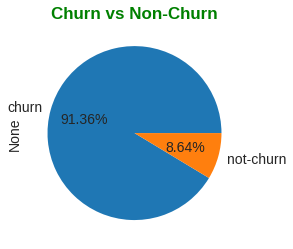

In [ ]:
fontdict = dict(color="green", fontsize=17, fontweight="bold")
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=14)

# draw pie chart for churn vs not-churn customers
plt.title("Churn vs Non-Churn", fontdict=fontdict)
df2.replace([0, 1], ["not-churn", "churn"]).groupby('churn').size().plot(kind='pie', autopct='%.2f%%')
plt.show()

**We can clearly see a `class imbalance` in this dataset**

### Histogram and Boxplots

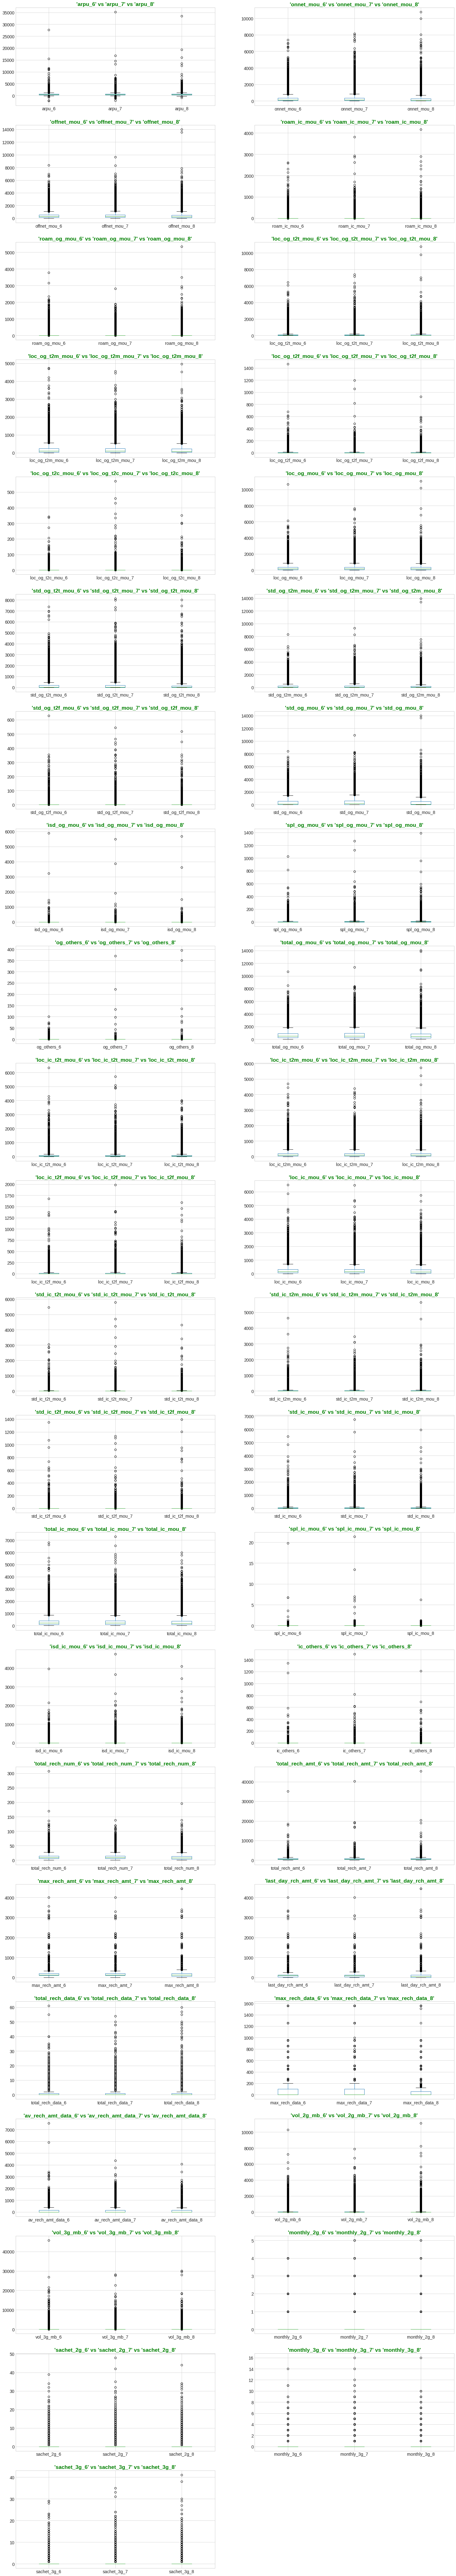

In [ ]:
# lets look boxplots
col_6 = col_filter("_6$", df2)
cols = 2
rows = len(col_6)//cols + 1
plt.figure(figsize=[25, 150])
for i, col in enumerate(col_6):
    _col_7 = col.replace("_6", "_7")
    _col_8 = col.replace("_6", "_8")
    ax = plt.subplot(rows, cols, i+1)
    df2[[col, _col_7, _col_8]].plot.box(ax=ax)
    ax.set_title(f"'{col}' vs '{_col_7}' vs '{_col_8}'", fontdict=fontdict)
plt.show()

- As we can see above almost all the columns in all months contains outliers.

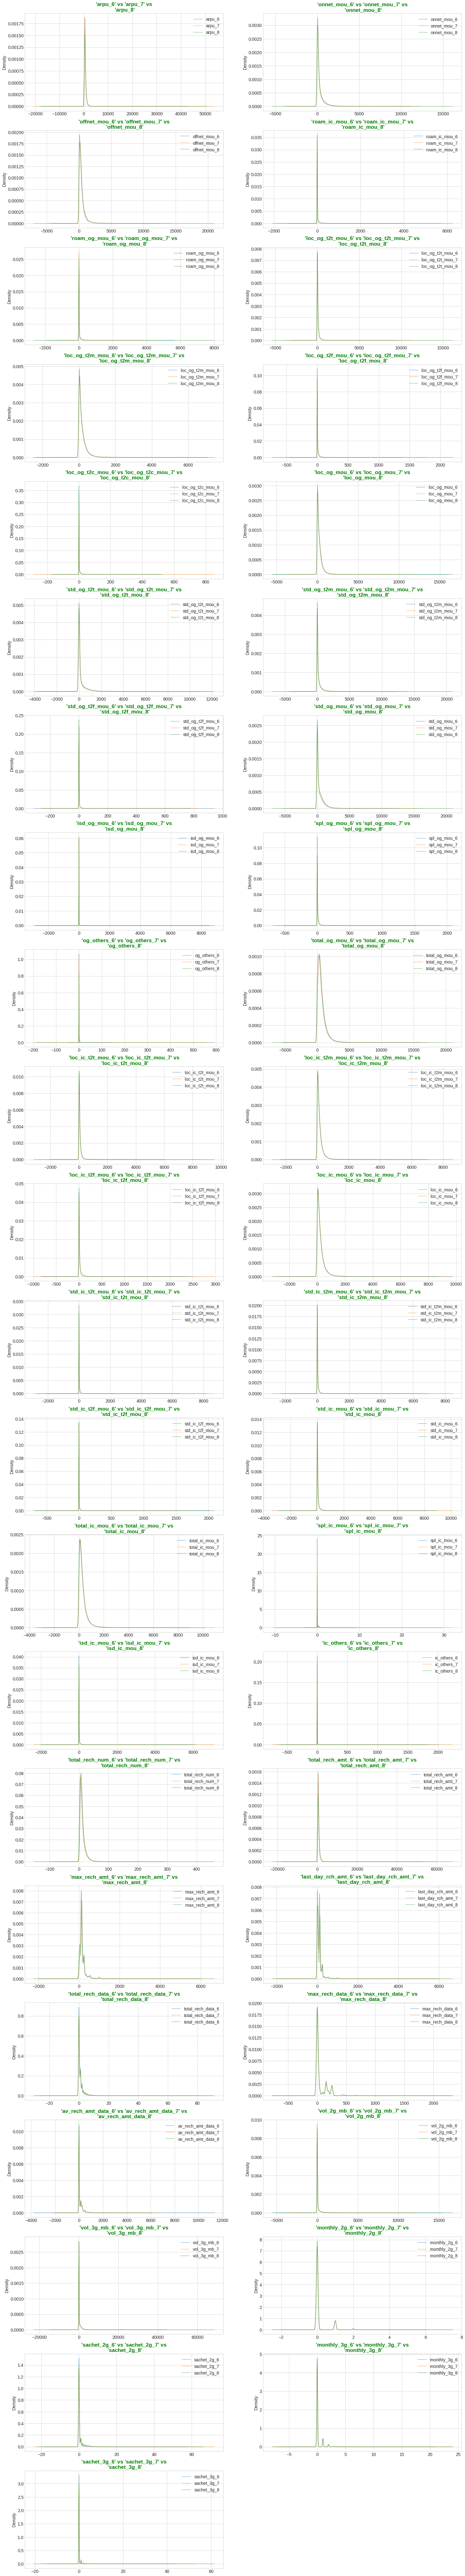

In [ ]:
# lets look at a distribution
col_6 = col_filter("_6$", df2)
cols = 2
rows = len(col_6)//cols + 1
plt.figure(figsize=[25, 150])
for i, col in enumerate(col_6):
    _col_7 = col.replace("_6", "_7")
    _col_8 = col.replace("_6", "_8")
    ax = plt.subplot(rows, cols, i+1)
    df2[[col, _col_7, _col_8]].plot.kde(ax=ax, alpha=0.5)
    ax.set_title(f"'{col}' vs '{_col_7}' vs\n '{_col_8}'", fontdict=fontdict)
plt.show()

- Each variable for every month follows similar pattern.
- We can see above all parameters are highly skewed
- Few are poorlt distributed: `os_others, loc_ic_t2t_mou,loc_ic_t2f_mou, std_ic_t2t_mou, std_ic_t2m_mou, spl_ic_mou, ic_others`
- Few features,`last_day_rch_amt, max_rech_amt, max_rech_data` ,are showing a slightly better distribution ther others.

## Bivariate Analysis

### Scatter Plots

Pairplots: Month 6 data and churn vs not-churn


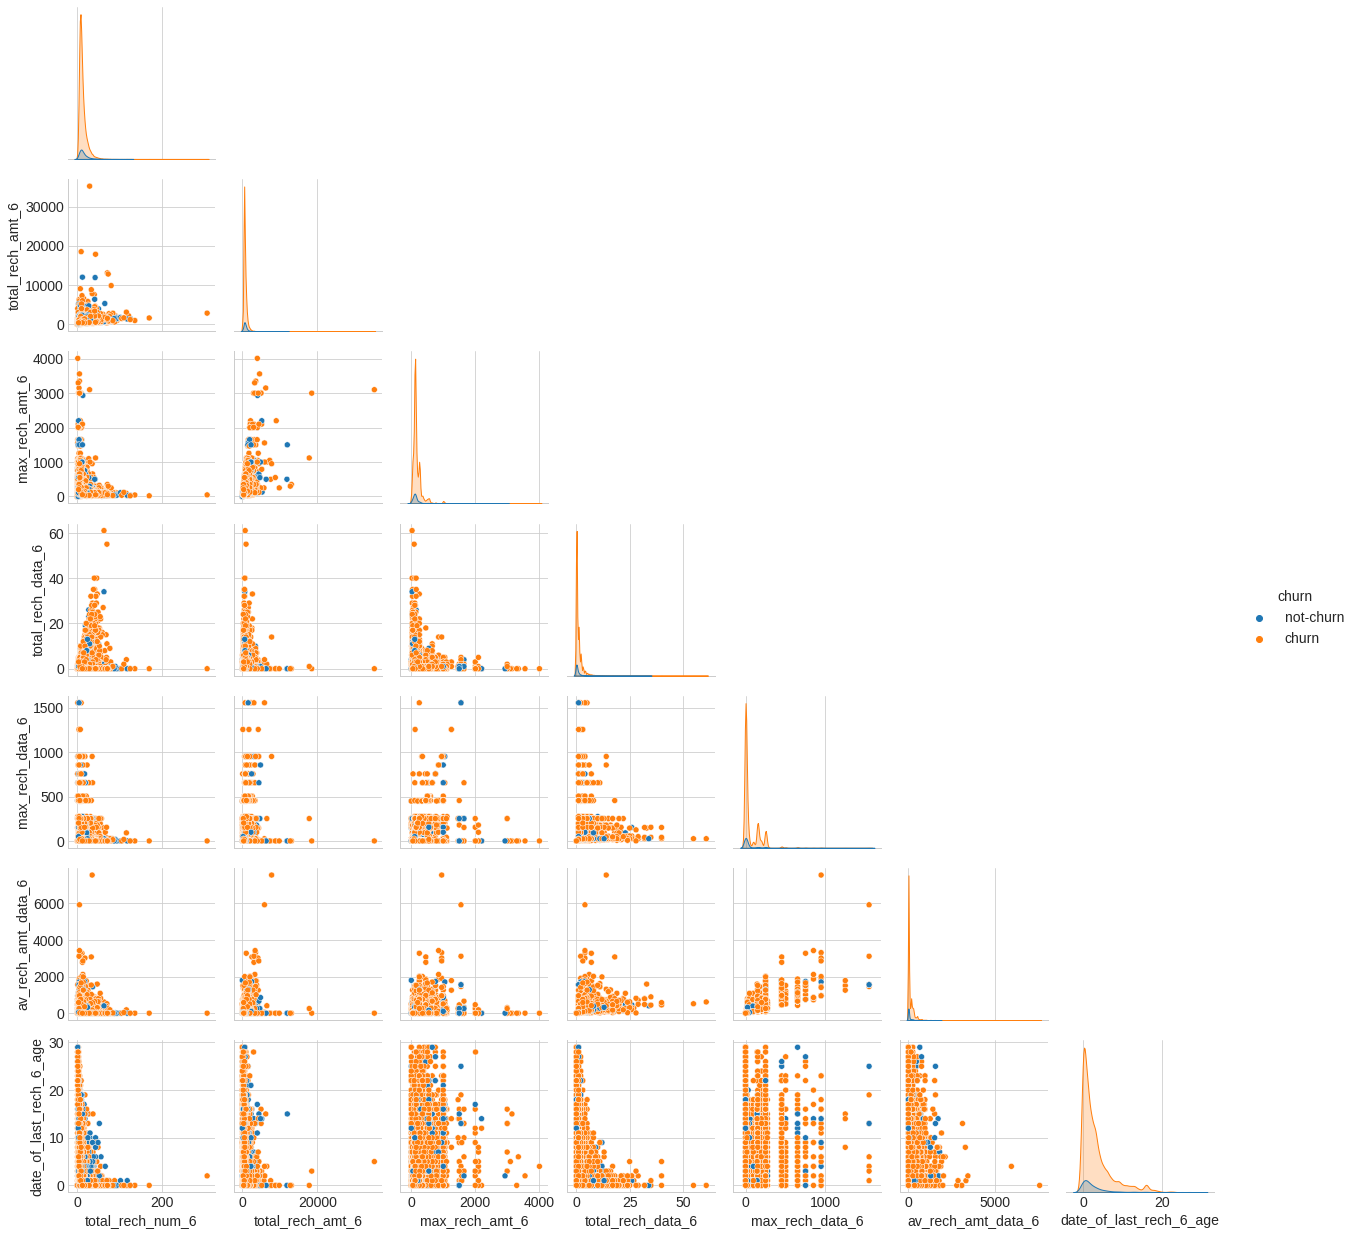

In [ ]:
col_rech6 = col_filter("_rec.*6", df2)
tmp = df2[col_rech6]
tmp['churn'] = df2['churn'].replace([1, 0], ["churn", "not-churn"])
# draw pair plot for month 6
print("Pairplots: Month 6 data and churn vs not-churn")
sns.pairplot(tmp, hue='churn', corner=True)
plt.show()

Pairplots: Month 7 data and churn vs not-churn


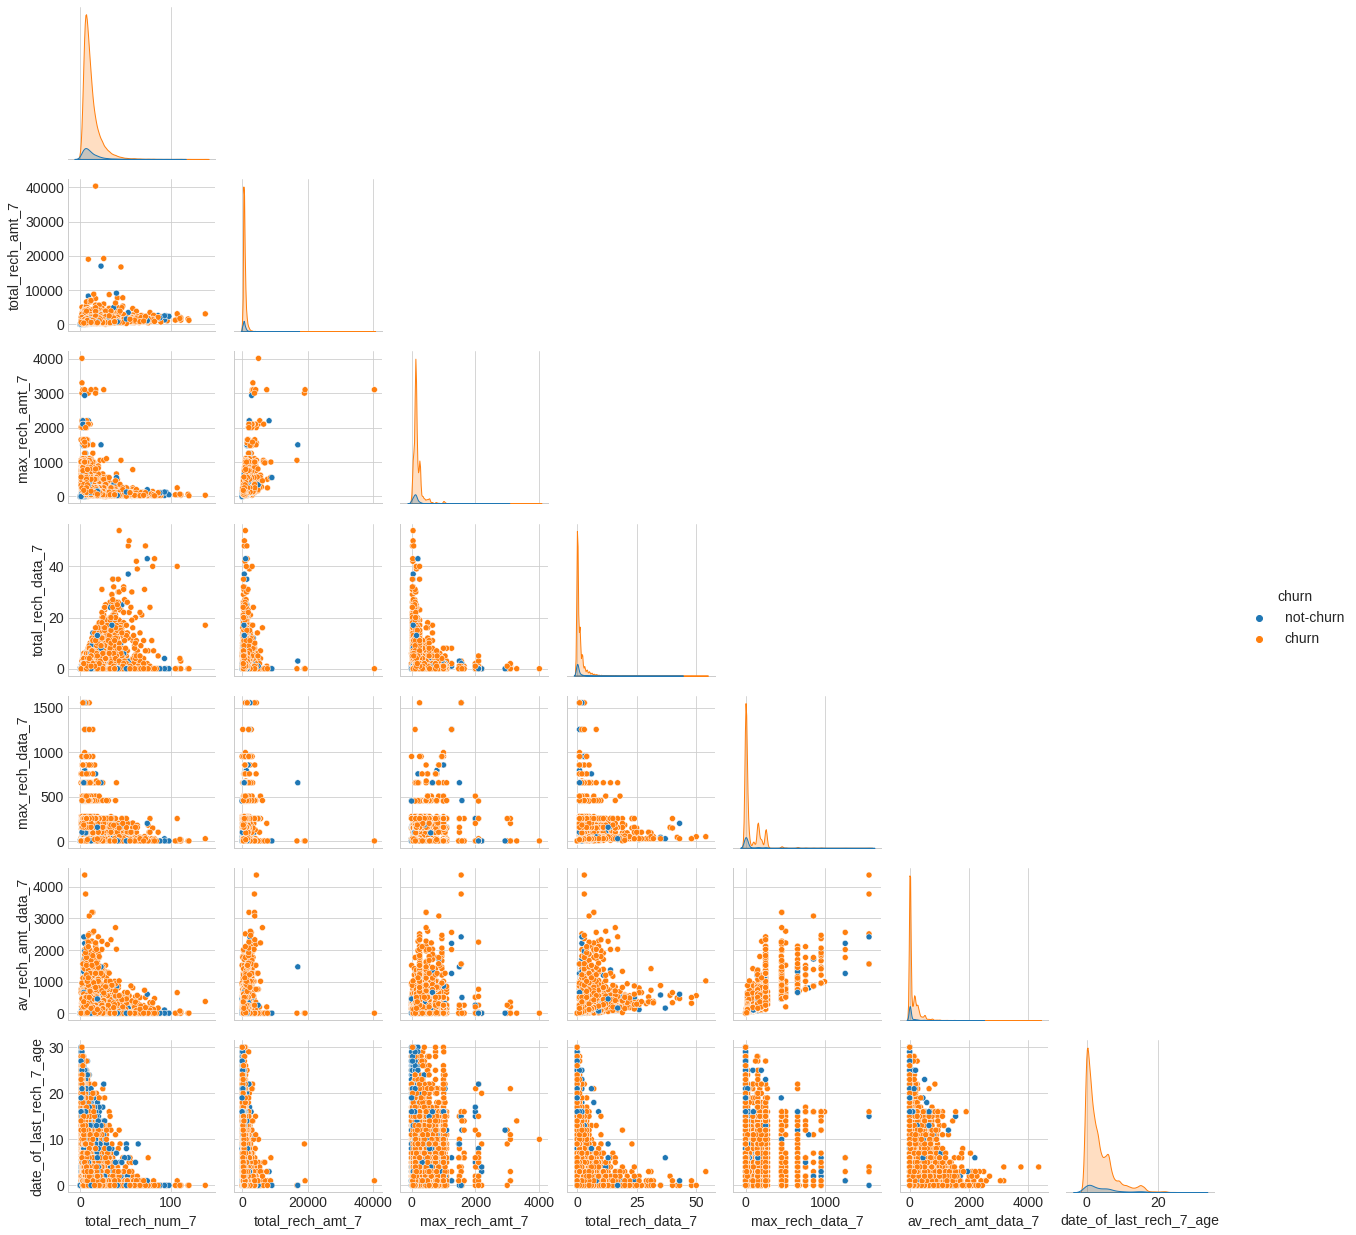

In [ ]:
col_rech = col_filter("_rec.*7", df2)
tmp = df2[col_rech]
tmp['churn'] = df2['churn'].replace([1, 0], ["churn", "not-churn"])
# draw pair plot for month 7
print("Pairplots: Month 7 data and churn vs not-churn")
sns.pairplot(tmp, hue='churn', corner=True)
plt.show()

Pairplots: Month 8 data and churn vs not-churn


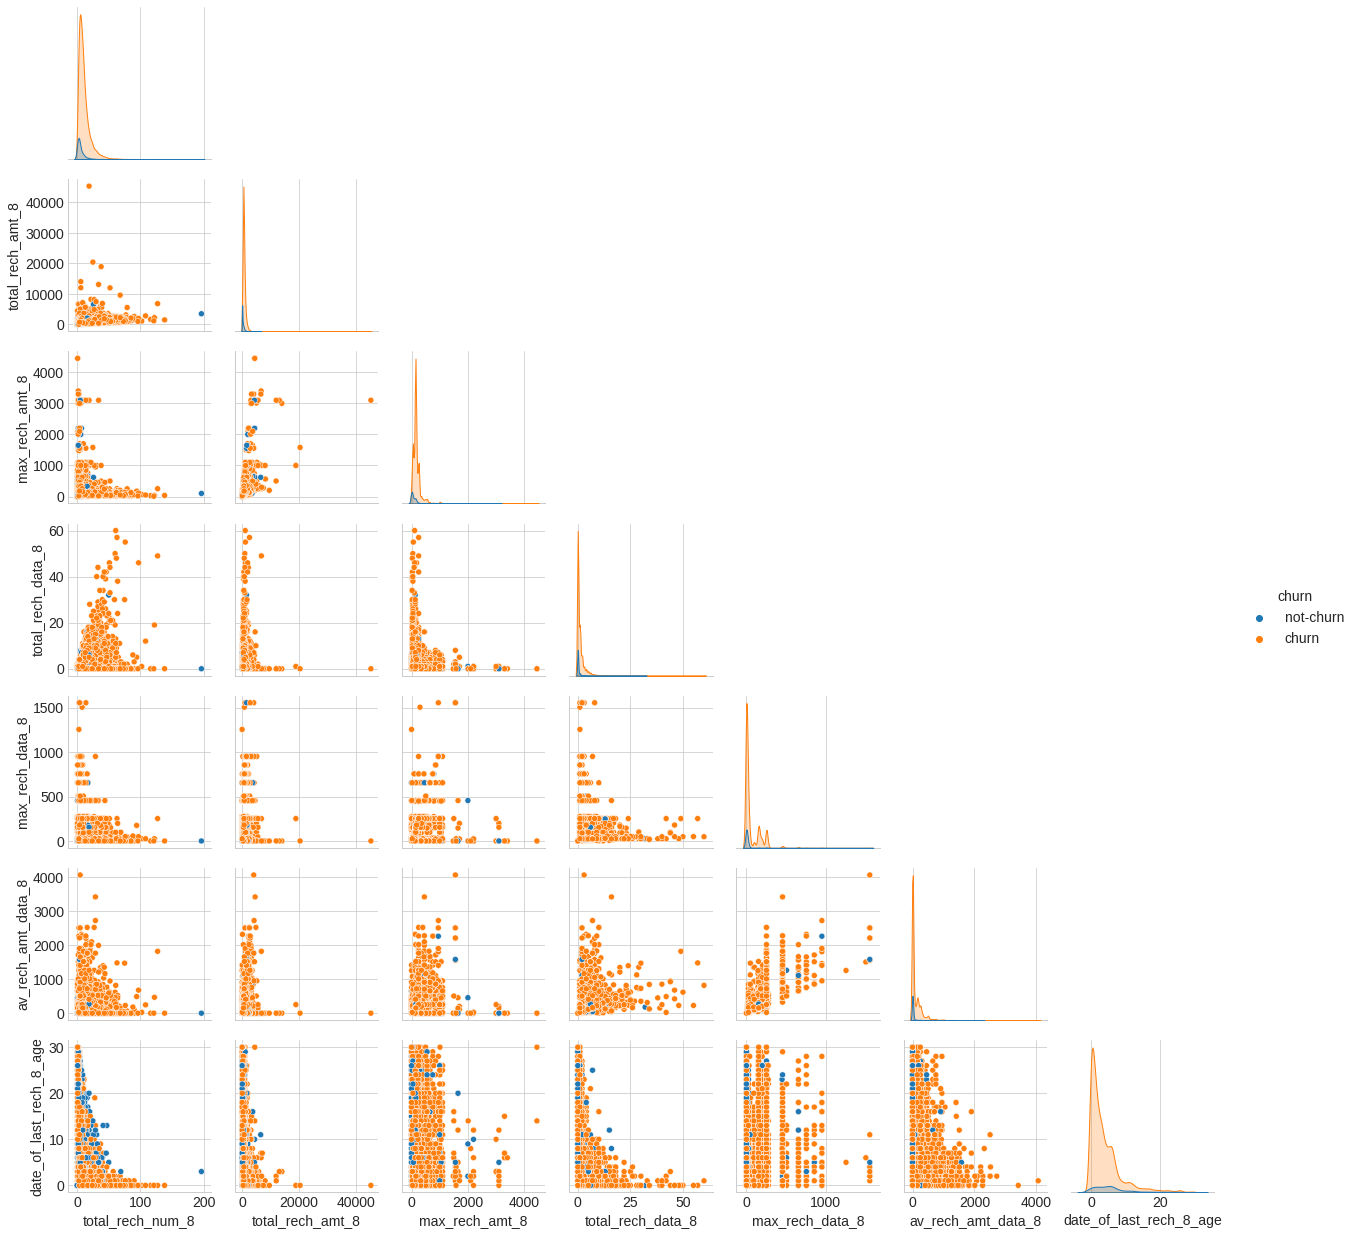

In [ ]:
col_rech = col_filter("_rec.*8", df2)
tgt = 'churn'
tmp = df2[col_rech]
tmp['churn'] = df2['churn'].replace([1, 0], ["churn", "not-churn"])
# draw pair plot for month 8
print("Pairplots: Month 8 data and churn vs not-churn")
sns.pairplot(tmp, hue='churn', corner=True)
plt.show()

- 

In [ ]:
df2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Data columns (total 137 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   arpu_6                   float64
 1   arpu_7                   float64
 2   arpu_8                   float64
 3   onnet_mou_6              float64
 4   onnet_mou_7              float64
 5   onnet_mou_8              float64
 6   offnet_mou_6             float64
 7   offnet_mou_7             float64
 8   offnet_mou_8             float64
 9   roam_ic_mou_6            float64
 10  roam_ic_mou_7            float64
 11  roam_ic_mou_8            float64
 12  roam_og_mou_6            float64
 13  roam_og_mou_7            float64
 14  roam_og_mou_8            float64
 15  loc_og_t2t_mou_6         float64
 16  loc_og_t2t_mou_7         float64
 17  loc_og_t2t_mou_8         float64
 18  loc_og_t2m_mou_6         float64
 19  loc_og_t2m_mou_7         float64
 20  loc_og_t2m_mou_8         float64
 21  loc_og_t2f_

## Multivariate Analysis

- <u>drop new columns created during 'HighValue customer'</u>
- <u>['av_rech_amt_data_7','max_rech_data_7','total_rech_data_7'] row wise imputation</u>
- <u>calculate age and drop the datetime columns</u>
- <u>KNNImputer for all numerical columns</u>
- <u>define churn valiables and drop temporaty columns</u>
- <u>drop churn phase columns</u>
- EDA
- feature balancing SMOTE
- PCA with LogisticRegression, Random forest, XGBooxt
- LogisticRegression, DT, Random Forest


# Modle Building - Churn

## Data Preparation

## Modelling

## Model Assesment

## Summary - Churn

# Modle Building - Best Features

## Data Preparation

## Modelling

## Model Assesment

## Summary - Best Feature

# Summary and Business Decisions